In [1]:
import os

In [2]:

os.chdir("../")

In [8]:
%pwd

'e:\\Projects\\E2E Emotion Detection from text\\Emotion-Detection-using-ML'

In [9]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path_X: Path
    test_data_path_target: Path
    model_path: Path
    all_params: dict
    metric_file_name: Path
    cm_file_name: Path
    mlflow_uri: str

In [10]:
from src.ML_emotion_detection.constants import *
from src.ML_emotion_detection.utils.common import read_yaml, create_directories, save_json

In [12]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.LogisticRegression
        # schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path_X=config.test_data_path_X,
            test_data_path_target=config.test_data_path_target,
            model_path = config.model_path,
            all_params=params,
            metric_file_name= config.metric_file_name,
            cm_file_name= config.cm_file_name,
            mlflow_uri = "https://dagshub.com/ArghyadipB/Emotion-Detection-using-ML.mlflow",
            # target_column = schema.name           
        )

        return model_evaluation_config

In [13]:
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)
from src.ML_emotion_detection.utils.common import load_bin
import mlflow
import dagshub
from urllib.parse import urlparse  
import matplotlib.pyplot as plt

[2024-11-26 13:18:33,949: WARNING: font_manager: Matplotlib is building the font cache; this may take a moment.]
[2024-11-26 13:20:17,039: INFO: font_manager: generated new fontManager]


In [ ]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
        
    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        weighted_precision = precision_score(actual, pred, average= 'weighted')
        weighted_recall = recall_score(actual, pred, average= 'weighted')
        weighted_f1 = f1_score(actual, pred, average= 'weighted')
        
        label_map = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
        }

        y_true_mapped = [label_map[label] for label in actual]
        y_pred_mapped = [label_map[label] for label in pred]

        cm = confusion_matrix(y_true_mapped, y_pred_mapped)
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))
        
        return accuracy, weighted_precision, weighted_recall, weighted_f1, cm_disp
    
    def log_into_mlflow(self):
        test_data_X = load_bin(self.config.test_data_path_X)
        test_data_target = load_bin(self.config.test_data_path_target)
        model = load_bin(self.config.model_path)
        
        dagshub.init(repo_owner='ArghyadipB', repo_name='Emotion-Detection-using-ML', mlflow=True)
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store= urlparse(mlflow.get_tracking_uri()).scheme
        
        
         
        with mlflow.start_run():
            predicted_output = model.predict(test_data_X)
            (acc, weighted_pre, weighted_rec, weighted_f1, conf_mat) = self.eval_metrics(test_data_target,
                                                                            predicted_output)
            
            conf_mat.plot(cmap=plt.cm.Blues, values_format='d')
            plt.savefig(self.config.cm_file_name)
            plt.close()
            
            scores = {"Accuracy": acc, "Weighted_precision": weighted_pre,
                    "Weighted_recall": weighted_rec, "Weighted_F1": weighted_f1}
            save_json(path=Path(self.config.metric_file_name), data=scores)
            
            mlflow.log_params(self.config.all_params)
            mlflow.log_metric("Accuracy", acc)
            mlflow.log_metric("Weighted Precision", weighted_pre)
            mlflow.log_metric("Weighted Recall", weighted_rec) 
            mlflow.log_metric("Weighted F1", weighted_f1)  
            mlflow.log_artifact(self.config.cm_file_name)
            
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name= "LogisticRegression")
            else:
                mlflow.sklearn.log_model(model, "model")
                 

[2024-11-26 13:34:46,677: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-11-26 13:34:46,682: INFO: common: yaml file: params.yaml loaded successfully]
[2024-11-26 13:34:46,686: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-11-26 13:34:46,689: INFO: common: created directory at: artifacts]
[2024-11-26 13:34:46,692: INFO: common: created directory at: artifacts/model_evaluation]
[2024-11-26 13:34:46,718: INFO: common: binary file loaded from: artifacts/data_transformation/X_test.joblib]
[2024-11-26 13:34:46,748: INFO: common: binary file loaded from: artifacts/data_transformation/y_test.joblib]
[2024-11-26 13:34:46,753: INFO: common: binary file loaded from: artifacts/model_trainer/log_reg_model.joblib]
[2024-11-26 13:34:48,088: INFO: _client: HTTP Request: GET https://dagshub.com/api/v1/repos/ArghyadipB/Emotion-Detection-using-ML "HTTP/1.1 200 OK"]


Initialized MLflow to track repo "ArghyadipB/Emotion-Detection-using-ML"

[2024-11-26 13:34:48,096: INFO: helpers: Initialized MLflow to track repo "ArghyadipB/Emotion-Detection-using-ML"]


Repository ArghyadipB/Emotion-Detection-using-ML initialized!

[2024-11-26 13:34:48,110: INFO: helpers: Repository ArghyadipB/Emotion-Detection-using-ML initialized!]
[2024-11-26 13:34:50,261: INFO: common: json file saved at: artifacts\model_evaluation\metrics.json]


2024/11/26 13:39:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\ARGHYADIP\AppData\Local\Temp\tmpi41qdelu\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.2', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/26 13:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[2024-11-26 13:40:20,770: WARNING: connectionpool: Retrying (JitteredRetry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /ArghyadipB/Emotion-Detection-using-ML.mlflow/api/2.0/mlflow-artifacts/artifacts/200ed7f4f40a43aea05c3027bf57eb55/04d1b3cf46d54026bd35a6418e157c57/artifacts/model/conda.yaml]


Successfully registered model 'LogisticRegression'.
2024/11/26 13:40:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1
Created version '1' of model 'LogisticRegression'.


🏃 View run polite-foal-969 at: https://dagshub.com/ArghyadipB/Emotion-Detection-using-ML.mlflow/#/experiments/0/runs/04d1b3cf46d54026bd35a6418e157c57
🧪 View experiment at: https://dagshub.com/ArghyadipB/Emotion-Detection-using-ML.mlflow/#/experiments/0


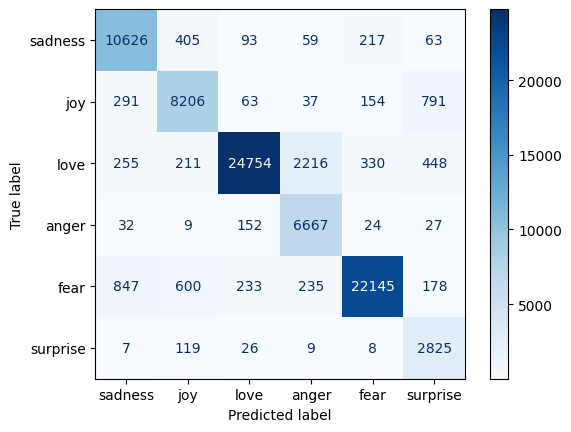

In [21]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
    model_evaluation_config.log_into_mlflow()
except Exception as e:
    raise e